In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%matplotlib inline 
import numpy as np 
import cv2
import csv
import matplotlib.pyplot as plt 
import random 

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
from os import listdir
from os.path import isfile, join
Covid_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Covid/train") if f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Covid/train", f))]
Covid_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Covid/test") if f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Covid/test", f))]
Normal_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Normal/train") if  f.startswith('.') == False ]
Normal_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Normal/test") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Normal/test", f))]
Pneumonia_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Pneumonia/train") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Pneumonia/train", f))]
Pneumonia_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Pneumonia/test") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Pneumonia/test", f))]

In [5]:
len(Normal_train_files)

180

In [6]:
def read_data(file_names_list, data_list, labels_list, path, label):
  for i in range(len(file_names_list)):
    img = cv2.imread(path + file_names_list[i])
    img = cv2.resize(img,(224,224))
    data_list.append(img)
    labels_list.append(label)
  return data_list, labels_list

In [7]:
train_list = []
test_list = []
train_labels = []
test_labels = []

path = "/content/drive/My Drive/Colab Notebooks/Covid/train/"
label = 0
train_list, train_labels = read_data(Covid_train_files, train_list, train_labels, path, label)
print(len(train_list),len(train_labels))
path = "/content/drive/My Drive/Colab Notebooks/Normal/train/"
label = 1
train_list, train_labels = read_data(Normal_train_files, train_list, train_labels, path, label)
print(len(train_list),len(train_labels))
path = "/content/drive/My Drive/Colab Notebooks/Pneumonia/train/"
label = 2
train_list, train_labels = read_data(Pneumonia_train_files, train_list, train_labels, path, label)
print(len(train_list),len(train_labels))
path = "/content/drive/My Drive/Colab Notebooks/Covid/test/"
label = 0
test_list, test_labels = read_data(Covid_test_files, test_list, test_labels, path, label)
print(len(test_list),len(test_labels))
path = "/content/drive/My Drive/Colab Notebooks/Normal/test/"
label = 1
test_list, test_labels = read_data(Normal_test_files, test_list, test_labels, path, label)
print(len(test_list),len(test_labels))
path = "/content/drive/My Drive/Colab Notebooks/Pneumonia/test/"
label = 2
test_list, test_labels = read_data(Pneumonia_test_files, test_list, test_labels, path, label)
print(len(test_list),len(test_labels))

179 179
359 359
539 539
30 30
60 60
90 90


In [8]:
k = 10
folds = list(StratifiedKFold(n_splits = k, shuffle=True, random_state=1).split(train_list, train_labels))

In [9]:
def one_hot(l):
    for i in range(len(l)):
        if(l[i] == 0):
            l[i] = [1,0,0]
        if(l[i] == 1):
            l[i] = [0,1,0]
        if(l[i] == 2):
            l[i] = [0,0,1]
    return l

In [10]:
train_labels = one_hot(train_labels)
test_labels = one_hot(test_labels)

In [11]:
train_list = np.array(train_list)
train_labels = np.array(train_labels)
test_list = np.array(test_list)
test_labels = np.array(test_labels)

In [12]:
from tensorflow.keras.models import load_model
CheXNet_pretrained_model = load_model("/content/drive/My Drive/Colab Notebooks/94482_23620_cw_keras_chexpert_pretrained_chexnet_512_6_001_0.414_0.808.h5")

In [13]:
CheXNet_pretrained_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [14]:
len(CheXNet_pretrained_model.layers)

432

In [20]:
def CheXNet_get():
    K.set_learning_phase(1)
    ModelX = load_model("/content/drive/My Drive/Colab Notebooks/94482_23620_cw_keras_chexpert_pretrained_chexnet_512_6_001_0.414_0.808.h5")
    ModelX_out = ModelX.layers[-6].output
    ModelX_out = GlobalAveragePooling2D()(ModelX_out)
    ModelX_out = Dense(256, activation = "relu", name="dense_one")(ModelX_out)
    ModelX_out = Dropout(0.3, name="dropout_add1")(ModelX_out)
    ModelX_out = Dense(512, activation = "relu", name="dense_two")(ModelX_out)
    ModelX_out = Dropout(0.3, name="dropout_add2")(ModelX_out)
    ModelX_out = Dense(3, activation="softmax", name="dense_out")(ModelX_out)
    ModelDN = Model(ModelX.input, ModelX_out)
    for layer in ModelX.layers:
      if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
          layer.trainable = True
          K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
          K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False
    #for layer in ModelX.layers:
      #layer.trainable = False

    
    opt = SGD(lr=0.01, decay=0.01 / 25)
    ModelDN.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    
    return(ModelDN)

In [21]:
model = CheXNet_get()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [22]:
trainAug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience =  5)
checkpoint_callback = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Covid_19_CheXNet/CheXNet_Checkpoint"+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [24]:
len(train_list)

539

In [25]:
models_each_folds = []
models_evaluations = []
HXs = []

for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_app = train_list[train_idx]
    Y_train_app = train_labels[train_idx]
    VALX = train_list[val_idx]
    VALY= train_labels[val_idx]
    
    print("[INFO] training head...")
    
    modelX = CheXNet_get()
    
    HX = modelX.fit_generator(
    trainAug.flow(X_train_app,Y_train_app, batch_size=8),
    steps_per_epoch=len(X_train_app) // 8,
    validation_data=(VALX, VALY),
    validation_steps=len(VALX) // 8,
    callbacks=[early_stopping_callback, checkpoint_callback],
    epochs=30)
    
    K.set_learning_phase(0)
    predIdxsX = modelX.predict(test_list.astype('float16'), batch_size=8)
    predIdxsX = np.argmax(predIdxsX, axis=1)
    print(classification_report(test_labels.argmax(axis=1), predIdxsX,target_names=["COVID-19","NORMAL","PNEUMONIA"]))
    
    models_each_folds.append(modelX)
    HXs.append(HX)
    
    Loss, Acc = modelX.evaluate(test_list,test_labels)
    models_evaluations.append([Loss, Acc])
    print("(Loss, Acc):",modelX.evaluate(test_list,test_labels))
  


Fold  0
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 1.0933 - accuracy: 0.3816
Epoch 00001: val_loss improved from inf to 1.05053, saving model to /content/drive/My Drive/Colab Notebooks/Covid_19_CheXNet/CheXNet_Checkpoint.h5
60/60 [==============================] - 14s 240ms/step - loss: 1.0933 - accuracy: 0.3816 - val_loss: 1.0505 - val_accuracy: 0.3333
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 1.0178 - accuracy: 0.4675
Epoch 00002: val_loss improved from 1.05053 to 0.84480, saving model to /content/drive/My Drive/Colab Notebooks/Covid_19_CheXNet/CheXNet_Checkpoint.h5
60/60 [==============================] - 8s 141ms/step - loss: 1.0178 - accuracy: 0.4675 - val_loss: 0.8448 - val_accuracy: 0.6852
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.5409
Epoch 00003: val_loss improved from 0.84480 to 0

In [26]:
test_acc = []
train_acc = []
val_acc = []

for i in range(10):
  H = HXs[i]
  train_acc.append(np.mean(HXs[i].history["accuracy"]))
  val_acc.append(np.mean(HXs[i].history["val_accuracy"]))
  test_acc.append(models_evaluations[i][1])

test_acc_mean = np.mean(test_acc)
train_acc_mean = np.mean(train_acc)
val_acc_mean = np.mean(val_acc)
print(" train accuracy mean:",train_acc_mean,"\n",
      "validation accuracy mean:",val_acc_mean,"\n",
      "test accuracy mean:",test_acc_mean)

 train accuracy mean: 0.7675613627518102 
 validation accuracy mean: 0.8289563370278323 
 test accuracy mean: 0.7555555582046509


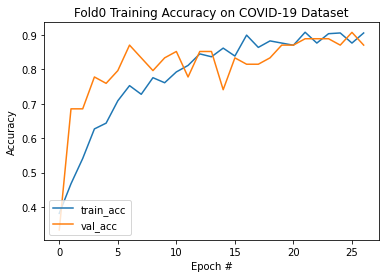

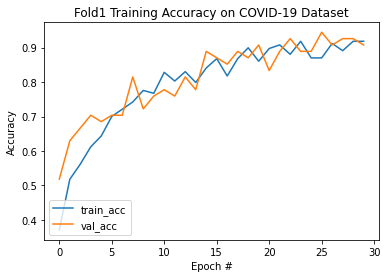

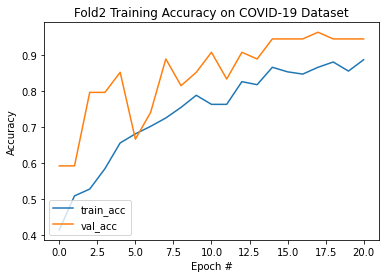

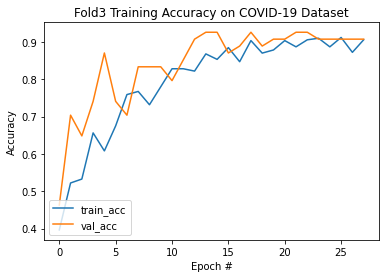

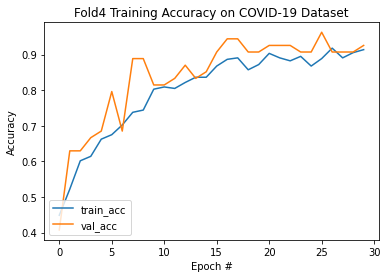

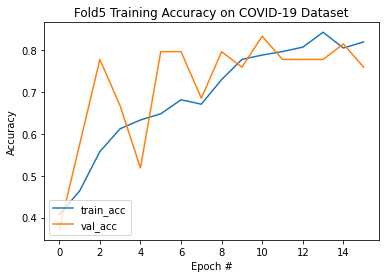

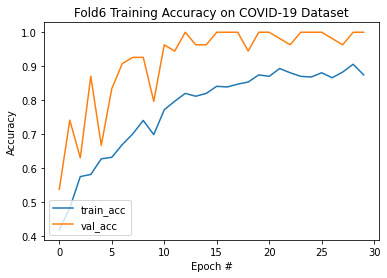

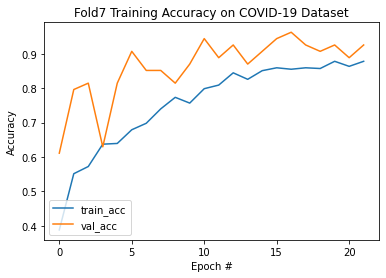

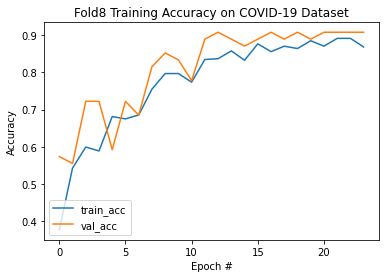

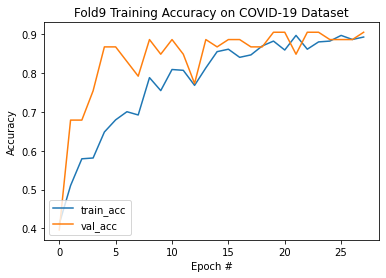

In [27]:
for i in range(len(HXs)):
  H = HXs[i]
  N = len(H.history["accuracy"])
  plt.figure()
  plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
  plt.title("Fold"+ str(i)+" Training Accuracy on COVID-19 Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower left")
  plt.savefig('/content/drive/My Drive/Colab Notebooks/Covid_19_CheXNet/Fold_'+ str(i)+'CheXNet_Training_Accuracy.png', bbox_inches='tight')

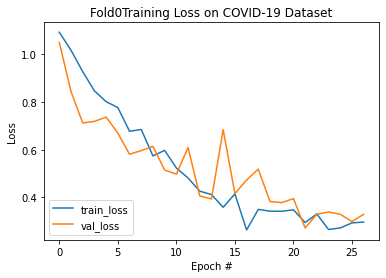

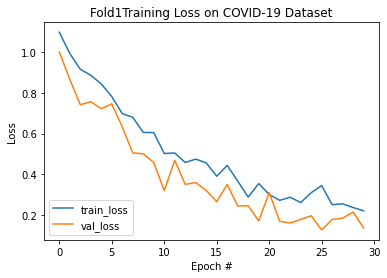

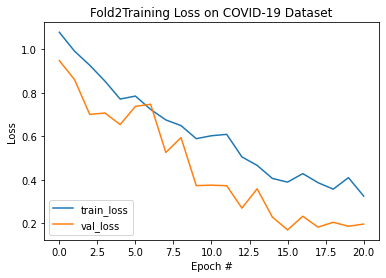

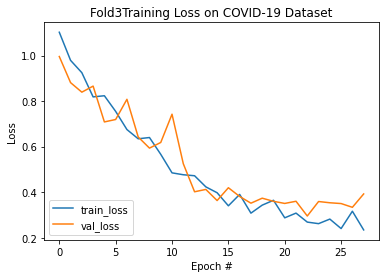

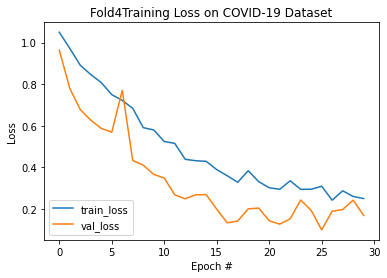

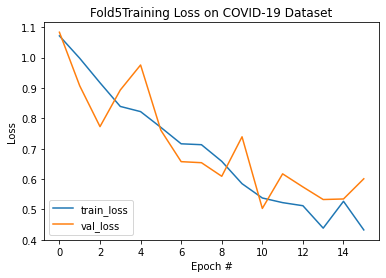

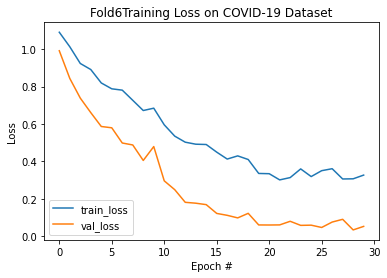

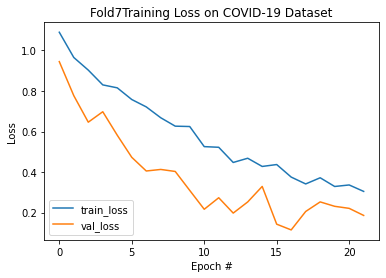

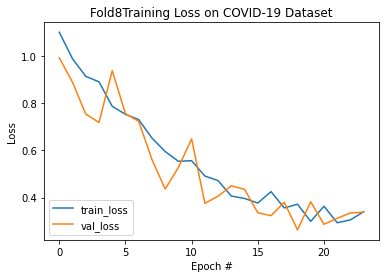

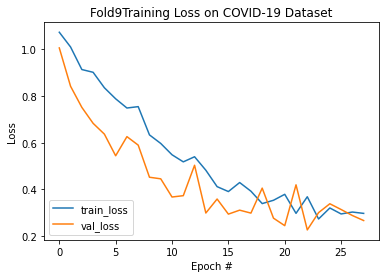

In [28]:
for i in range(len(HXs)):
  H = HXs[i]
  N = len(H.history["accuracy"])
  plt.figure()
  plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
  plt.title("Fold"+ str(i)+"Training Loss on COVID-19 Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  plt.savefig('/content/drive/My Drive/Colab Notebooks/Covid_19_CheXNet/Fold_'+ str(i)+'CheXNet_Training_Loss.png', bbox_inches='tight')

In [29]:
modelX = CheXNet_get()

HX = modelX.fit_generator(
    trainAug.flow(train_list, train_labels, batch_size=8),
    steps_per_epoch=len(train_list) // 8,
    validation_data=(test_list, test_labels),
    validation_steps=len(test_list) // 8,
    callbacks=[early_stopping_callback, checkpoint_callback],
    epochs=100)

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 1.0614 - accuracy: 0.4313WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 11 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss did not improve from 0.03418
67/67 [==============================] - 11s 167ms/step - loss: 1.0614 - accuracy: 0.4313 - val_loss: 0.9388 - val_accuracy: 0.6111
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 0.5574WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 11 batches). You may need to use the repeat() function when building your dataset.

Epoch 00002: val_loss did not improve from 0.03418
67/67 [==============================] - 8s 

In [30]:
K.set_learning_phase(0)
predIdxsX = modelX.predict(test_list.astype('float16'), batch_size=15)
predIdxsX = np.argmax(predIdxsX, axis=1)
print(classification_report(test_labels.argmax(axis=1), predIdxsX,target_names=["COVID-19","NORMAL","PNEUMONIA"]))

              precision    recall  f1-score   support

    COVID-19       0.74      0.97      0.84        30
      NORMAL       0.83      0.97      0.89        30
   PNEUMONIA       0.94      0.50      0.65        30

    accuracy                           0.81        90
   macro avg       0.84      0.81      0.80        90
weighted avg       0.84      0.81      0.80        90



In [31]:
Loss, Acc = modelX.evaluate(test_list,test_labels)
print("(Loss, Acc):",modelX.evaluate(test_list,test_labels))

3/3 [==============================] - 0s 67ms/step - loss: 0.5089 - accuracy: 0.8111
(Loss, Acc): [0.5088831782341003, 0.8111110925674438]


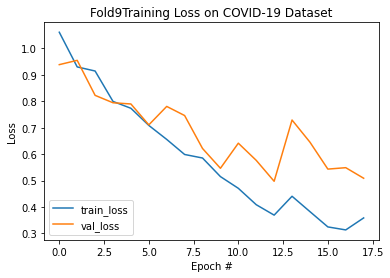

In [32]:
H = HX
N = len(H.history["accuracy"])
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Fold"+ str(i)+"Training Loss on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("/content/drive/My Drive/Colab Notebooks/Covid_19_CheXNet/CheXNet_final_model_Training_Loss.png", bbox_inches='tight')

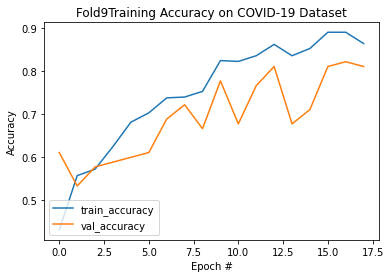

In [33]:
H = HX
N = len(H.history["accuracy"])
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
plt.title("Fold"+ str(i)+"Training Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/drive/My Drive/Colab Notebooks/Covid_19_CheXNet/CheXNet_final_model_Training_Accuracy.png", bbox_inches='tight')

In [34]:
modelX.save("/content/drive/My Drive/Colab Notebooks/Covid_19_CheXNet/CheXNet_final_model.h5")